In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import IPython.display as d

#Config mapping for CKKS setups
cfg_map = {
    "light": "CKKS Light",
    "med": "CKKS Medium",
    "heavy": "CKKS Heavy"
}

# Load logs 
base_dir = "."  
all_data = {}

for cfg_key, config_name in cfg_map.items():
    runs = []
    for run_id in range(1, 11):  # Assuming 10 runs
        run_folder = f"exp_{cfg_key}_r{run_id}"
        if not os.path.isdir(run_folder):
            continue

        # Find the log_server_* subfolder
        subfolders = [
            f for f in os.listdir(run_folder)
            if f.startswith("log_server_") and os.path.isdir(os.path.join(run_folder, f))
        ]

        if not subfolders:
            continue  # Skip if no server log folder found

        log_folder = os.path.join(run_folder, subfolders[0])  # Assume only one matching folder
        log_path = os.path.join(log_folder, "server_log.csv")

        if os.path.exists(log_path):
            df = pd.read_csv(log_path)
            df["Run"] = run_id
            runs.append(df)

    all_data[config_name] = runs




In [ ]:
#Average Training Time Summary
train_time_summary = {}

for config, runs in all_data.items():
    all_times = []
    for df in runs:
        if not df.empty and "Round Duration (s)" in df.columns:
            all_times.extend(df["Round Duration (s)"].dropna().tolist())

    if all_times:
        train_time_summary[config] = round(np.mean(all_times), 2)

for config, avg_time in train_time_summary.items():
    print(f"{config}: {avg_time} seconds")


CKKS Light: 28.02 seconds
CKKS Medium: 26.51 seconds
CKKS Heavy: 34.94 seconds


/tmp/ipykernel_102538/2525208386.py:41: RuntimeWarning: Mean of empty slice
  "mean": np.nanmean(f1_array, axis=0),
/tmp/ipykernel_102538/2525208386.py:47: RuntimeWarning: Mean of empty slice
  "mean": np.nanmean(time_array, axis=0),


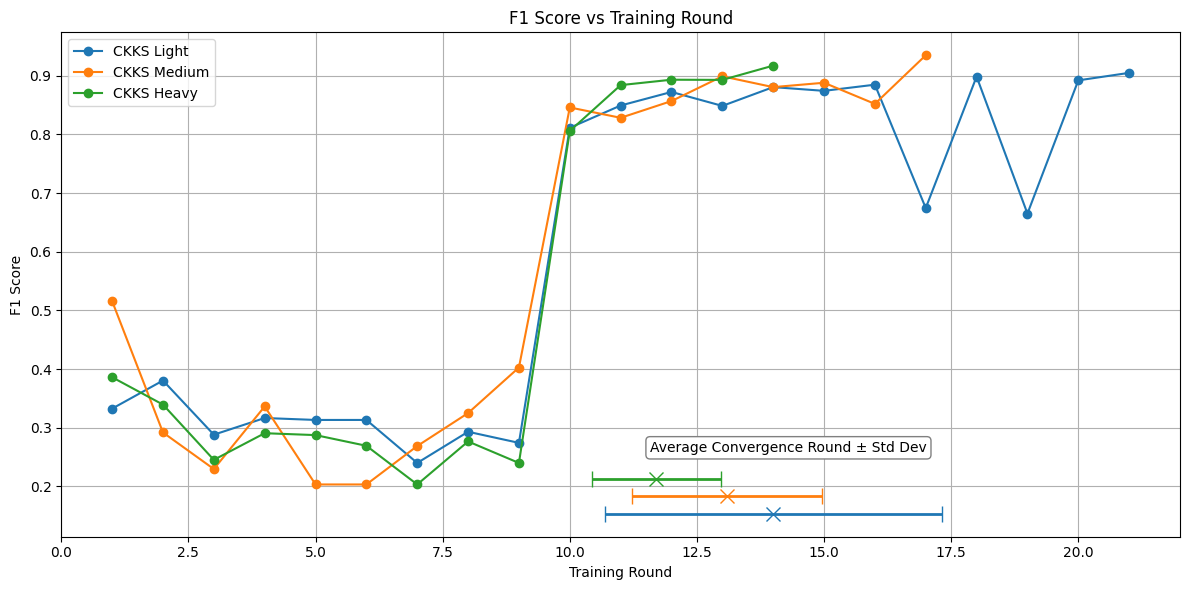

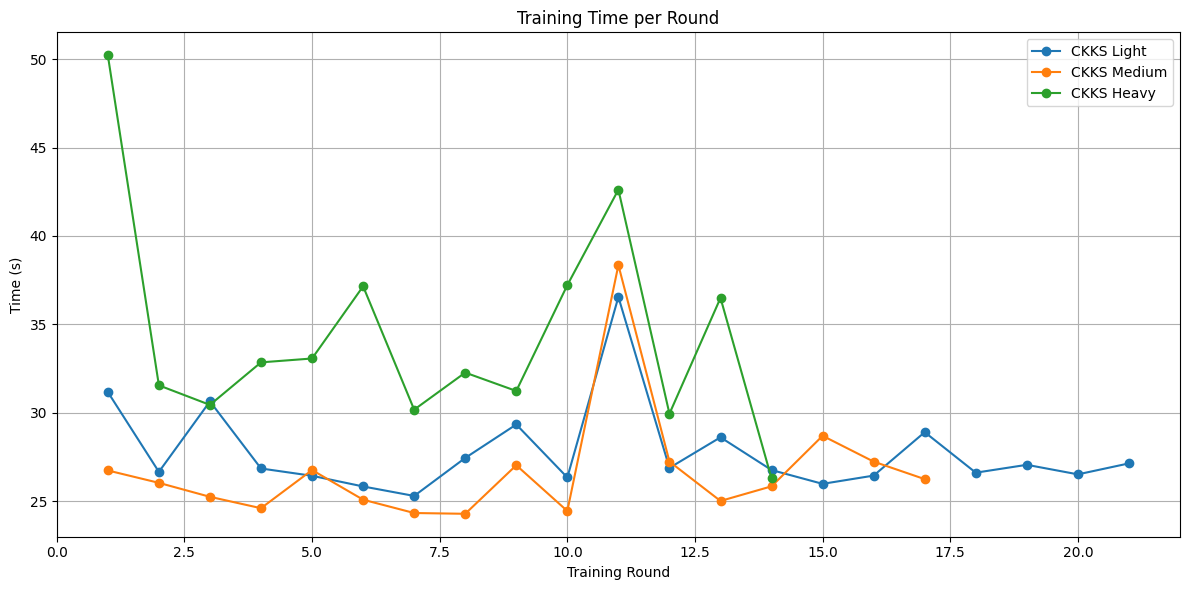

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Toggle STD DEV Visualization 
SHOW_STD_DEV = False
USE_ERROR_BARS = False

#Setup
max_rounds = 0
f1_stats = {}
time_stats = {}

# Compute max rounds and gather data
for config, runs in all_data.items():
    max_rounds = max(max_rounds, max(len(df) for df in runs if not df.empty))

for config, runs in all_data.items():
    f1_matrix = []
    time_matrix = []
    stop_rounds = []

    for df in runs:
        if df.empty:
            continue
        f1_series = df["F1 Score"].values
        time_series = df["Round Duration (s)"].values
        stop_rounds.append(len(f1_series))

        f1_padded = np.full(max_rounds, np.nan)
        time_padded = np.full(max_rounds, np.nan)
        f1_padded[:len(f1_series)] = f1_series
        time_padded[:len(time_series)] = time_series

        f1_matrix.append(f1_padded)
        time_matrix.append(time_padded)

    f1_array = np.vstack(f1_matrix)
    time_array = np.vstack(time_matrix)

    f1_stats[config] = {
        "mean": np.nanmean(f1_array, axis=0),
        "std": np.nanstd(f1_array, axis=0),
        "stop_rounds": stop_rounds
    }

    time_stats[config] = {
        "mean": np.nanmean(time_array, axis=0),
        "std": np.nanstd(time_array, axis=0),
        "stop_rounds": stop_rounds
    }

rounds = np.arange(1, max_rounds + 1)
colors = plt.cm.tab10.colors

# F1 Score Plot with stacked convergence markers
plt.figure(figsize=(12, 6))

# Compute position for markers
min_y = np.inf
for stats in f1_stats.values():
    min_y = min(min_y, np.nanmin(stats["mean"]))
base_marker_y = min_y - 0.05
marker_spacing = 0.03

#plot each config
for idx, (config, stats) in enumerate(f1_stats.items()):
    mean = stats["mean"]
    std = stats["std"]
    stop_rounds = stats["stop_rounds"]
    color = colors[idx]

    # Plot F1 score curve
    if SHOW_STD_DEV:
        if USE_ERROR_BARS:
            plt.errorbar(rounds, mean, yerr=std, label=config, fmt='-o', capsize=4, color=color)
        else:
            plt.plot(rounds, mean, label=config, color=color)
            plt.fill_between(rounds, mean - std, mean + std, alpha=0.3, color=color)
    else:
        plt.plot(rounds, mean, label=config, color=color, marker='o')

    #Average convergence marker
    avg_stop = np.mean(stop_rounds)
    std_stop = np.std(stop_rounds)
    marker_y = base_marker_y + idx * marker_spacing
    plt.errorbar(avg_stop, marker_y, xerr=std_stop, fmt='x', color=color,
                 markersize=10, capsize=6, elinewidth=2)

#Add annotation
top_label_y = base_marker_y + (len(f1_stats)) * marker_spacing - 0.075
plt.annotate("Average Convergence Round ± Std Dev",
             xy=(0.65, top_label_y), xycoords='axes fraction',
             ha='center', fontsize=10,
             bbox=dict(boxstyle="round", fc="white", ec="gray"))

plt.title("F1 Score vs Training Round")
plt.xlabel("Training Round")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Training Time Plot 
plt.figure(figsize=(12, 6))
for idx, (config, stats) in enumerate(time_stats.items()):
    mean = stats["mean"]
    std = stats["std"]
    color = colors[idx]

    if SHOW_STD_DEV:
        if USE_ERROR_BARS:
            plt.errorbar(rounds, mean, yerr=std, label=config, fmt='-o', capsize=4, color=color)
        else:
            plt.plot(rounds, mean, label=config, color=color)
            plt.fill_between(rounds, mean - std, mean + std, alpha=0.3, color=color)
    else:
        plt.plot(rounds, mean, label=config, color=color, marker='o')

plt.title("Training Time per Round")
plt.xlabel("Training Round")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


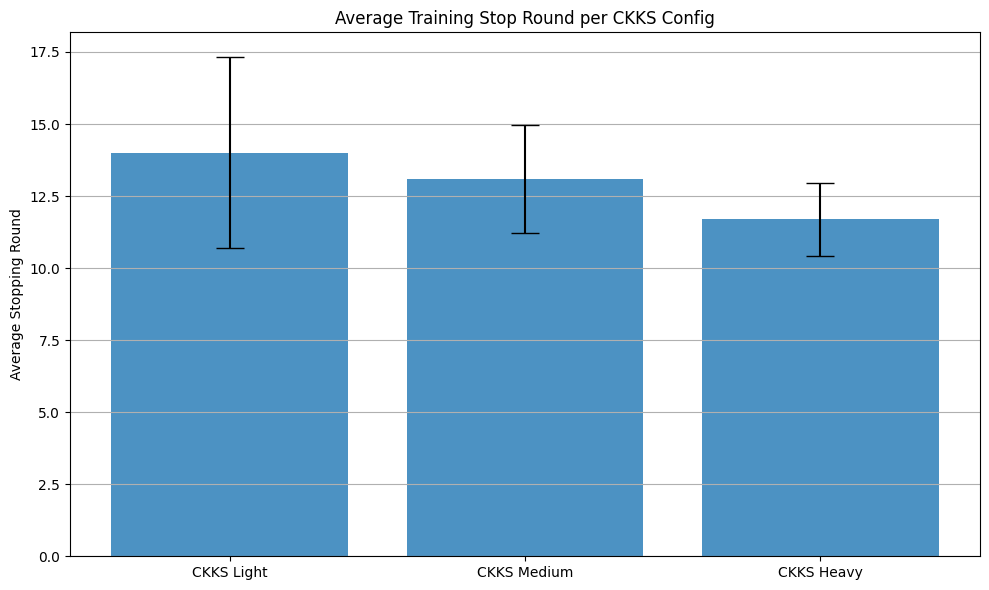

In [4]:
# === Average Stopping Round Visualization ===
config_names = []
avg_stop_rounds = []
std_stop_rounds = []

for config, stats in f1_stats.items():
    stop_rounds = stats["stop_rounds"]
    config_names.append(config)
    avg_stop_rounds.append(np.mean(stop_rounds))
    std_stop_rounds.append(np.std(stop_rounds))

plt.figure(figsize=(10, 6))
plt.bar(config_names, avg_stop_rounds, yerr=std_stop_rounds, capsize=10, alpha=0.8)
plt.ylabel("Average Stopping Round")
plt.title("Average Training Stop Round per CKKS Config")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
